In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

from keras.layers import LSTM

Using TensorFlow backend.


In [106]:
# set parameters:

batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

print('Loading data...')
dataset = pd.read_csv('CYP1A2_fixpka.smi', sep= ' ', header=None)
X_SMILES, y = dataset.iloc[:,:-1], dataset.iloc[:, -1]

#Library of unique characters. The first element is not used for future padding
char_lib=["ZMY"]

#Find characters of sequences and build a library
for index, SMILESsequence in X_SMILES.iterrows():
    for letter in SMILESsequence[0]:
        if not letter in char_lib:            
            char_lib.append(letter)
#print(char_lib)

X=[]
#SMILES sequence to an array
for index, SMILESsequence in X_SMILES.iterrows():
    sequenceArray=[]
    for letter in SMILESsequence[0]:
        sequenceArray.append(char_lib.index(letter))
    X.append(sequenceArray)
    
X=sequence.pad_sequences(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=428)

print('data loaded')

max_features = X_train.shape[1]
maxlen = X_train.shape[1]

Loading data...
data loaded


In [3]:
print(X_train.shape)

(11922, 226)


In [4]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters=1000,
                 kernel_size=7,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))

model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [111]:
from keras.callbacks import ModelCheckpoint
import keras
import numpy as np

class CustomCallbacks(keras.callbacks.Callback):
    def __init__(self, filename="CYP1A2_conv1.hdf5", monitor='val_acc'):
        self.filename = filename
        self.monitor = monitor
        if 'acc' in self.monitor or self.monitor.startswith('fmeasure') or 'val_acc' in self.monitor:
                self.monitor_op = np.greater
                self.best = -np.Inf
        else:
                self.monitor_op = np.less
                self.best = np.Inf
        
    def on_train_begin(self, logs={}):        
        self.losses = []
        self.acc = []
        self.val_acc =[]
        self.val_losses=[]
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.val_losses.append(logs.get('val_loss'))   
        print("acc:" , logs.get('acc'), 
              ", loss: " , logs.get('loss'),
              ", val_acc: " , logs.get('val_acc'),
              ", val_loss: " , logs.get('val_loss'))
        
        
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
        else:
            if self.monitor_op(current, self.best):
                print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, self.monitor, self.best,
                                     current, self.filename))
                self.best = current                       
                self.model.save(self.filename, overwrite=True)
            else:
                print('Epoch %05d: %s did not improve' %  (epoch, self.monitor))
        
        
my_callbacks=CustomCallbacks()


In [112]:
model.fit(X_train, y_train,
          batch_size=100,
          epochs=10,
          callbacks=[my_callbacks],
          validation_split=0.2,
          verbose=0)



acc: 0.972947486644 , loss:  0.0682885978585 , val_acc:  0.90020966155 , val_loss:  0.426420591787
Epoch 00000: val_acc improved from -inf to 0.90021, saving model to CYP1A2_conv1.hdf5
acc: 0.972632921991 , loss:  0.0628834712117 , val_acc:  0.888050336758 , val_loss:  0.478877697101
Epoch 00001: val_acc did not improve
acc: 0.975254288307 , loss:  0.0613415037013 , val_acc:  0.904402528919 , val_loss:  0.395097530363
Epoch 00002: val_acc improved from 0.90021 to 0.90440, saving model to CYP1A2_conv1.hdf5
acc: 0.975044575167 , loss:  0.0617168014241 , val_acc:  0.885115329075 , val_loss:  0.520485490373
Epoch 00003: val_acc did not improve
acc: 0.971374663415 , loss:  0.0694924040499 , val_acc:  0.88846962182 , val_loss:  0.493907629819
Epoch 00004: val_acc did not improve
acc: 0.974520302411 , loss:  0.0624296808 , val_acc:  0.896855373053 , val_loss:  0.398241888802
Epoch 00005: val_acc did not improve
acc: 0.97452030523 , loss:  0.0610394130928 , val_acc:  0.892662492438 , val_loss:

In [113]:
y_score=model.predict_proba(X_test)
model.evaluate(X_test, y_test, verbose=0)

2912/2981 [============================>.] - ETA: 0s

[0.50805164003574144, 0.89332438778933243]

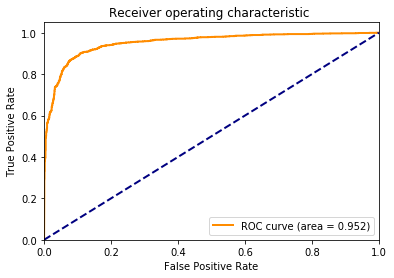

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



y_score_get_value=[]
for item in y_score:
    y_score_get_value.append(item[0])
    
fpr, tpr, _ = roc_curve(y_test, y_score_get_value)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.savefig("roc.svg", format="svg")
plt.show()


